In [ ]:
import snowflake.snowpark as snp
from snowflake.snowpark import functions as F
from snowflake.snowpark import types as T
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## ML Engineering

- In this section of the demo, we will utilize Snowpark's Python client-side Dataframe API to do some feature engineering.
- In the second part, we will use Weather data from the Marketplace to check wether squirrels can predict a bad winter... 
    - This is not something a regular Data Engineer would do, but looks like we have a squirrel fan here : )


### 1. Load  credentials and connect to Snowflake

In [ ]:
from steps.snowpark_connection import snowpark_connect
session, state_dict = snowpark_connect('./include/state.json')
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())


We will use Snowpark to do feature engineering and utilize Snowflake warehouses and compute.

Snowpark Python offers a very similar API to query and transform data in Snowflake entirely using Snowflake virtual warehouses.

 - Snowpark operations are executed lazily on the server, which reduces the amount of data transferred between your client and the Snowflake database.

- The core abstraction in Snowpark is the DataFrame, which represents a set of data and provides methods to operate on that data. In your client code, you construct a DataFrame object and set it up to retrieve the data that you want to use (for example, the columns containing the data, the filter to apply to rows, etc.).

- The data isn’t retrieved at the time when you construct the DataFrame object. Instead, when you are ready to retrieve the data, you can perform an action that evaluates the DataFrame objects and sends the corresponding SQL statements to the Snowflake database for execution.


### 2.  Load Data

In [ ]:
snowdf = session.table(state_dict['table_name'])

### 3.  Feature Engineering

Experts say that a squirrel might show signs of stress when it makes certain sounds (kuks or quaas) or flags its tail. 
Learn how squirrles talk in only 3 minutes: https://www.youtube.com/watch?v=r6y3moxAtXQ

Below we are summarizing a squirrel's complex hbehaviour into 3 main categories in order to assess their state of mind. We want to know if a squirrel:
* is active
* is stressed by predators or simply in distress
* feels comfy around humans

We are going to use these high-level characteristics to find the happiest squirrels in Central Park!

In [ ]:
def generate_features(snowdf):
    snowdf = snowdf.with_column('HAS_ACTIVITY',F.when( \
                                             (F.col("RUNNING").cast("int") + F.col("CHASING").cast("int") + F.col("CLIMBING").cast("int") + \
                                             F.col("EATING").cast("int") + F.col("FORAGING").cast("int")) >=1, F.lit(1)) \
                                             .otherwise(F.lit(0))) \
               .with_column('IS_STRESSED', F.when( \
                                             (F.col("KUKS").cast("int") + F.col("QUAAS").cast("int") + F.col("TAIL_FLAGS").cast("int")) >=1, F.lit(1)) \
                                             .otherwise(F.lit(0))) \
               .with_column('COMFY_WITH_HUMANS', F.when( \
                                             (F.col("APPROACHES").cast("int") + F.col("INDIFFERENT").cast("int") + F.col("TAIL_TWITCHES").cast("int")) >=1, F.lit(1)) \
                                             .otherwise(F.lit(0))) 
    return snowdf
     


In [ ]:
snowdf_transformed = generate_features(snowdf)

In [ ]:
snowdf_transformed.select(F.col('COMFY_WITH_HUMANS'),F.col("APPROACHES"), F.col("INDIFFERENT"), F.col("TAIL_TWITCHES")).show(10)


Now let's instantly and securely access up-to-date weather information to uncover insights about the winter. 

### 4. Browse the Marketplace
Log in to the Snowflake UI with the `Jack` user and password created in step 00-Setup.  
  
Click on [Marketplace](https://app.snowflake.com/marketplace) on the left side bar.

You will see many different types of data ranging from finance and trading to COVID statistics and geospatial datasets.  
  
Search for `Snowpark` in the search bar at the top. And select the tile named [Snowpark for Python - Hands-on-Lab - Weather Data](https://app.snowflake.com/marketplace/listing/GZSOZ1LLE9).

This dataset is provided by Weather Source for the Snowpark hands-on-lab and provides OnPoint Historical Weather Data in daily format for New York City ZIP Code - 10007.  
  
The sample data is in Celcius and covers the time period from June 1, 2013 to present. The data is updated daily and includes the following supported weather parameters: precipitation, temperature, wind speed & direction and humidity.

- Click on `Get Data` on the right side. 
- Click on `Options`.
- Enter `SQUIRRELY_WEATHER` for the database name.  
- Select `PUBLIC` for the role access if not already selected.  
- Read the terms and conditions and click on `Get Data`.

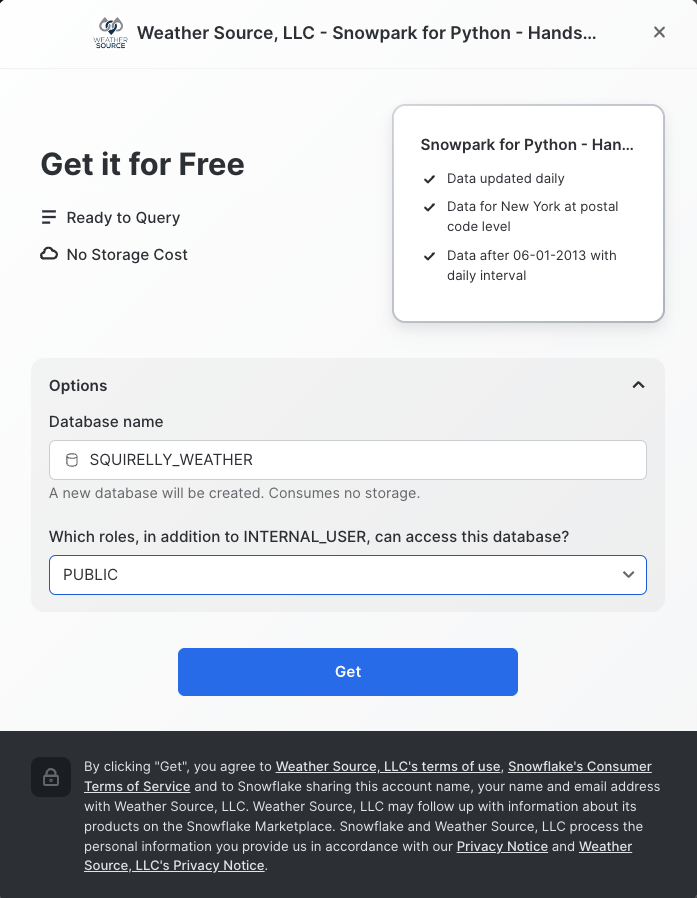

In [1]:
from IPython.core.display import Image
Image(filename='./include/marketplace.png')

In [ ]:
state_dict['weather_database_name'] = 'SQUIRRELY_WEATHER'
state_dict['weather_table_name'] = state_dict['weather_database_name']+'.ONPOINT_ID.HISTORY_DAY'
state_dict['weather_view_name'] = 'WEATHER'
import json
with open('./include/state.json', 'w') as sdf:
    json.dump(state_dict, sdf)

In [ ]:
def generate_weather_df(session, weather_table_name):

    weather_df = session.table(weather_table_name)\
                       .filter(F.col('POSTAL_CODE') == '10007')\
                       .select(F.col('DATE_VALID_STD').alias('DATE'), 
                               F.col('TOT_PRECIPITATION_MM').alias('PRECIP'), 
                               F.round(F.col('AVG_TEMPERATURE_FEELSLIKE_2M_C'), 2).alias('TEMP'))\
                       .sort('DATE', ascending=True)
    return weather_df

In [ ]:

weather_df = generate_weather_df(session, state_dict['weather_table_name'])
weather_df.show()
weather_df.select(F.min('DATE'), F.max('DATE')).show()

In [ ]:
train_snowdf = snowdf_transformed.join(weather_df, 'DATE', 'inner').sort('DATE', ascending=True)
train_snowdf.show(2)

Again, check the date range after the join.

In [ ]:
train_snowdf.select(F.min('DATE'), F.max('DATE')).show()

### 5. Save results back to Snowflake

In [ ]:
# save engineered features back to snowflake
train_snowdf.write.mode("overwrite").save_as_table("squirrels_engineered_features")

### 6. (Optional) Test Hypothesis

 Squirrels gathering nuts in a flurry, Will cause snow to gather in a hurry!!!
 - We want to test if the squirrely activity is a predictor for 

In [ ]:
train_agg = train_snowdf.group_by(F.col('DATE')).agg([F.avg(F.col('TEMP')), F.count(F.col('UNIQUE_SQUIRREL_ID'))]) \
    .with_column_renamed(F.col("AVG(TEMP)") , "TEMP") \
    .with_column_renamed(F.col("COUNT(UNIQUE_SQUIRREL_ID)") , "CNT")

train_agg.show(2)

In [ ]:
df = train_agg.to_pandas()
df.head()

In [ ]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15, 8))
df1 = pd.melt(df, id_vars=['DATE'], value_vars=['CNT', 'TEMP'])
ax = sns.lineplot(x='DATE', y='value', hue='variable', data=df1)

Let's calculate historical temparature for January and check if the census tells us something valuable!

In [ ]:
# calculate average weather temperatures in January, which is know to be the coldest month in NY
weather_subset = weather_df.select(F.year(F.col('DATE')).alias("YEAR"), F.month(F.col('DATE')).alias("MONTH"), F.col('TEMP')) \
    .filter((F.col('MONTH')==1) & (F.col('YEAR')<=2019))
weather_subset.group_by(F.col('YEAR'), F.col('MONTH')).avg(F.col('TEMP')).sort('YEAR', ascending=True).show()

Hmmm, it's seems that we do not have enough data to make any conclusions. But we can always start our own yearly squirrel census to validate this hypothesis!

In [ ]:
session.close()